# 📊 Analyse ROC - Système de reconnaissance faciale

Ce notebook permet de :
- Générer les embeddings faciaux à partir d'images de test avec InsightFace (ArcFace)
- Visualiser la distribution des similarités (positives vs négatives)
- Tracer la courbe ROC et suggérer un seuil optimal

**Structure attendue des fichiers :**
```
static/test/
├── emp1/
│   ├── ref.jpg
│   ├── test1.jpg
├── emp2/
│   ├── ref.jpg
│   ├── test1.jpg
```


In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import insightface

# Initialiser InsightFace
model = insightface.app.FaceAnalysis(name='buffalo_l')
model.prepare(ctx_id=0, det_size=(640, 640))

C:\Users\s.herivalisoa\PycharmProjects\FaceAttendanceProject\venv\lib\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:121: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\s.herivalisoa/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\s.herivalisoa/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\s.herivalisoa/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\s.herivalisoa/.insightface\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\s.herivalisoa/.insightface\models\buffalo_l\w600k_r50.onn

In [22]:
# Fonction pour générer l'embedding à partir d'une image
def get_embedding(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    faces = model.get(img)
    if len(faces) == 0:
        return None
    return faces[0].embedding

In [31]:
# Charger toutes les images test
base_dir = "../static/test_images"
embeddings = {}

for person in os.listdir(base_dir):
    person_dir = os.path.join(base_dir, person)
    if not os.path.isdir(person_dir): continue
    
    emb_list = []
    for i, fname in enumerate(os.listdir(person_dir)):
        img_path = os.path.join(person_dir, fname)
        
        if i < 10:
            if i%9 == 0:
                print(img_path)
            emb = get_embedding(img_path)
            if emb is not None:
                emb_list.append((fname, emb))
    embeddings[person] = emb_list

../static/test_images\Akshay Kumar\Akshay Kumar_0.jpg
../static/test_images\Akshay Kumar\Akshay Kumar_17.jpg
../static/test_images\Alexandra Daddario\Alexandra Daddario_0.jpg
../static/test_images\Alexandra Daddario\Alexandra Daddario_17.jpg
../static/test_images\Alia Bhatt\Alia Bhatt_0.jpg
../static/test_images\Alia Bhatt\Alia Bhatt_17.jpg
../static/test_images\Amitabh Bachchan\Amitabh Bachchan_0.jpg
../static/test_images\Amitabh Bachchan\Amitabh Bachchan_17.jpg
../static/test_images\Andrianina\a.jpg
../static/test_images\Andy Samberg\Andy Samberg_0.jpg
../static/test_images\Andy Samberg\Andy Samberg_17.jpg
../static/test_images\Anushka Sharma\Anushka Sharma_0.jpg
../static/test_images\Anushka Sharma\Anushka Sharma_17.jpg
../static/test_images\Baholy\test (1).jpg
../static/test_images\Billie Eilish\Billie Eilish_0.jpg
../static/test_images\Billie Eilish\Billie Eilish_17.jpg
../static/test_images\Brad Pitt\Brad Pitt_0.jpg
../static/test_images\Brad Pitt\Brad Pitt_106.jpg
../static/test

In [32]:
embeddings["Akshay Kumar"][0][1].shape

(512,)

In [33]:
# Générer les paires positives et négatives
positives = []
negatives = []

people = list(embeddings.keys())
for i, person in enumerate(people):
    samples = embeddings[person]
    for j in range(1, len(samples)):
        sim = np.dot(samples[0][1], samples[j][1]) / (np.linalg.norm(samples[0][1]) * np.linalg.norm(samples[j][1]))
        positives.append(sim)

    for other in people[i+1:]:
        other_samples = embeddings[other]
        for sample in other_samples[1:]:
            sim = np.dot(samples[0][1], sample[1]) / (np.linalg.norm(samples[0][1]) * np.linalg.norm(sample[1]))
            negatives.append(sim)

In [34]:
len(positives)

285

In [35]:
len(negatives)

5136

In [38]:
negatives = negatives[:285]

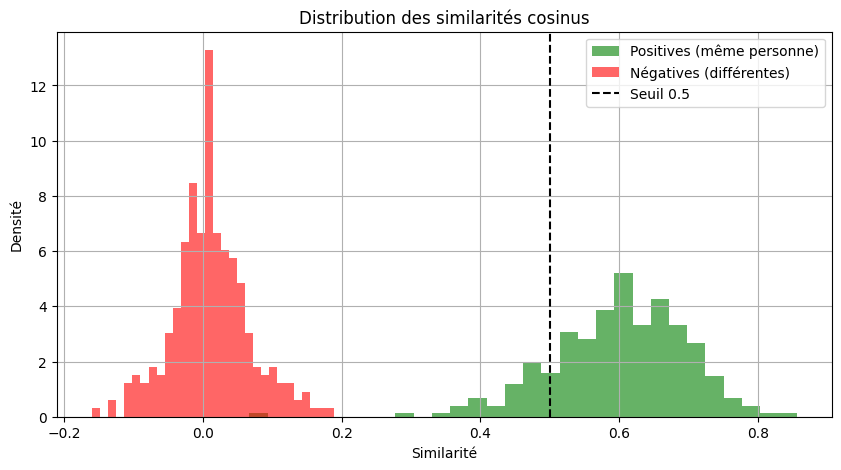

In [45]:
# Affichage de la distribution
plt.figure(figsize=(10,5))
plt.hist(positives, bins=30, alpha=0.6, label="Positives (même personne)", color="green", density=True)
plt.hist(negatives, bins=30, alpha=0.6, label="Négatives (différentes)", color="red", density=True)
plt.axvline(x=0.5, linestyle='--', color='black', label="Seuil 0.5")
plt.title("Distribution des similarités cosinus")
plt.xlabel("Similarité")
plt.ylabel("Densité")
plt.legend()
plt.grid(True)
plt.savefig('ROC.png')
plt.show()

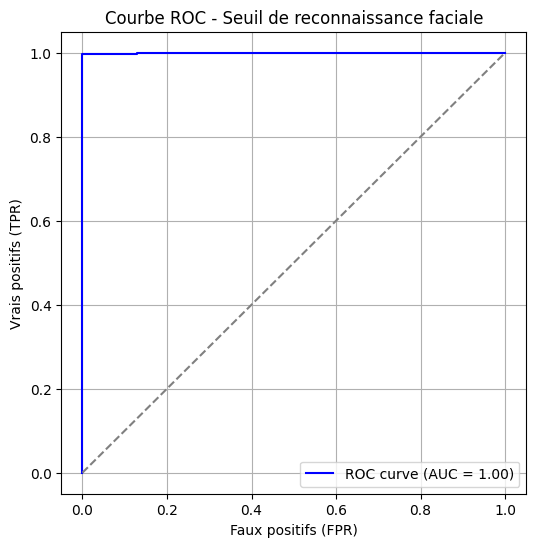

In [40]:
# Courbe ROC
y_true = [1]*len(positives) + [0]*len(negatives)
y_score = positives + negatives

fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("Faux positifs (FPR)")
plt.ylabel("Vrais positifs (TPR)")
plt.title("Courbe ROC - Seuil de reconnaissance faciale")
plt.legend()
plt.grid(True)
plt.show()

In [41]:
# Seuil optimal
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"🎯 Seuil optimal suggéré : {optimal_threshold:.2f}")

🎯 Seuil optimal suggéré : 0.28


In [42]:
thresholds

array([        inf,  0.8562696 ,  0.28015116,  0.0679414 ,  0.06686429,
       -0.1600403 ], dtype=float32)

In [43]:
tpr

array([0.        , 0.00350877, 0.99649123, 0.99649123, 1.        ,
       1.        ])

In [10]:
fpr

array([0., 0., 0., 1.])